# FIT5196 Assessment 2 
#### Student Name: Pichaphop Sunthornjittanon
#### Student ID: 31258301

Date: 30/9/21
 ##############################

Environment: Python 3.6.0 and Google Colab

## Introduction

Exploring and understanding the data is one of the most important parts of the data wrangling
process. You are required to perform graphical and/or non-graphical EDA methods to understand
the data first and then find the data problems. You are required to:

● Detect and fix errors in <student_id>_dirty.csv

● Impute the missing values in <student_id>_missing.csv

● Detect and remove outlier rows in <student_id>_outlier.csv
(outliers are to be found w.r.t. delivery_charges attribute)

## Importing libraries 

In [5]:
# Import required library

# Use for working with dataframe
import pandas as pd

# Use for regex
import re

# Use for working with multi-dimensional arrays and matrices
import numpy as np

# Use for dealing with sentimental analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Use for converting string of list to list
import ast

# Use for working with network 
import networkx as nx

# Use for training linear regression model
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Loading dataset

Firstly, we have to load datasets, which are :

1.31258301_dirty.csv

2.31258301_missing.csv 

3.31258301_outlier.csv

4.restaurant_data_student.csv

5.edges.csv

6.nodes.csv

 from the specified google drive directories and store them in dataframe format

In [6]:
# Mount Google Drive in the colab environment
from google.colab import drive

drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#### Load customised data from the share drive #### 
# Load 31258301_dirty to dirty_df
dirty_df = pd.read_csv('/content/drive/Shareddrives/FIT5196-s2-2021-tutorials/Assessment 2/student_data/31258301_dirty.csv')

# Load 31258301_missing to missing_df
missing_df = pd.read_csv('/content/drive/Shareddrives/FIT5196-s2-2021-tutorials/Assessment 2/student_data/31258301_missing.csv')

# Load 31258301_outlier to outlier_df
outlier_df = pd.read_csv('/content/drive/Shareddrives/FIT5196-s2-2021-tutorials/Assessment 2/student_data/31258301_outlier.csv')

In [8]:
#### Load supplementary data #### 
# Load restaurant data to restaurant_df
restaurant_df =  pd.read_csv('restaurant_data_student.csv')

# Load edge data to edge_df
edge_df =  pd.read_csv('edges.csv')

# Load node data to node_df
node_df =  pd.read_csv('nodes.csv')

## Task 1: Detecting and Fixing Anomalies in Dirty Dataset

Detect and fix errors in 31258301_dirty.csv

###1.1 Overall Exploratory Data Analysis(EDA) 

After the data has been loaded and stored into dataframe, we look at an overview of the data. First, we explore the dimensionality of the data and an example of how data looks like

In [9]:
# Look at the shape of the data (500 rows and 18 column)
print(dirty_df.shape)


(500, 18)


In [10]:
# Look at first 5 rows
dirty_df.head(5)

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD287671,REST0231,CUST03708,COUR2658,-37.807909,144.995935,2020-06-01,23:20:26,0,0,Car,"[('barbeque chicken', 1), ('pepper bbq chicken...",0,50.670,4065,10,7.21,3.6372
1,ORD251937,REST0944,CUST07692,COUR2647,-37.814212,145.011677,2020-09-06,13:15:09,1,1,Car,"[('pasta', 1), ('ginger tea', 1), ('pizza', 2)...",20,52.256,6610,16,8.30,7.0637
2,ORD138059,REST0231,CUST10327,COUR2639,-37.821490,145.005260,2020-09-03,04:13:11,0,0,Car,"[('paneer tikka', 3), ('hummus falafel', 1), (...",0,125.560,5855,14,9.01,3.9516
3,ORD069767,REST0677,CUST04780,COUR3599,-37.804762,144.924148,2020-10-07,01:30:59,0,0,Motorbike,"[('bamboo chicken biryani', 1), ('pasta', 2), ...",0,72.030,4051,8,8.59,3.7907
4,ORD133689,REST0761,CUST00284,COUR0186,-37.800288,144.936736,2020-08-10,16:01:19,0,0,Bike,"[('pita bread', 1), ('french fries', 2)]",45,26.675,1878,9,7.45,3.7900


We are working with 500 observations and 18 attributes. Next, we further look at data type and basic statistics in each column

In [11]:
# Inspect data type in each column
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   restaurant_id                  500 non-null    object 
 2   customer_id                    500 non-null    object 
 3   carrier_id                     500 non-null    object 
 4   customer_lat                   500 non-null    float64
 5   customer_lon                   500 non-null    float64
 6   date                           500 non-null    object 
 7   time                           500 non-null    object 
 8   is_peak_time                   500 non-null    int64  
 9   is_weekend                     500 non-null    int64  
 10  carrier_vehicle                500 non-null    object 
 11  shopping_cart                  500 non-null    object 
 12  coupon_discount                500 non-null    int

In [12]:
# Basic statistics for numerical data
dirty_df.describe()

,customer_lat,customer_lon,is_peak_time,is_weekend,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-35.619269,142.775957,0.200000,0.288000,15.100000,73.418234,2994.042000,9.626000,7.771980,4.258625
std,19.920844,19.922089,0.400401,0.453285,18.164523,36.184711,1631.744798,7.234002,1.041874,1.063719
min,-37.833267,-37.822472,0.000000,0.000000,0.000000,10.890000,94.000000,0.000000,5.960000,2.373200
25%,-37.818784,144.951949,0.000000,0.000000,0.000000,45.934500,1751.500000,4.750000,6.870000,3.416550
50%,-37.812772,144.966871,0.000000,0.000000,5.000000,67.617000,2771.500000,8.000000,7.630000,4.113800
75%,-37.806025,144.985091,0.000000,1.000000,40.000000,98.366000,4052.750000,12.250000,8.590000,4.952375
max,144.969411,145.020271,1.000000,1.000000,45.000000,224.130000,7689.000000,36.000000,9.540000,7.828400


In [13]:
# Basic statistics for categorical data
dirty_df.describe(include= 'O')

,order_id,restaurant_id,customer_id,carrier_id,date,time,carrier_vehicle,shopping_cart
count,500,500,500,500,500,500,500,500
unique,500,5,490,467,289,280,6,493
top,ORD176013,REST0231,CUST06645,COUR3366,2020-04-28,19:27:01,Bike,"[('brownie', 2), ('buttermilk', 3)]"
freq,1,115,2,3,6,7,175,2


According to specification,  numerical and categorical statistics summary, we found that:

- Max customer_lat  is unreasonably high (144.969411). Melbourn latitude is around - 37.8 and maximum possible latutude is 90, so we suspect this column to contain anomaly (maybe swap between latitude and longtitude)

- Min customer_lon is unreasonably low (-37.822472). Melbourn longtitude is around 144.96. Having too low longtitude is suspicious

- is_peak_time is a boolean denoting if order is delivered during peak time (Peak periods are the intervals 12:00:00pm - 1:59:59pm and 6:00:00pm - 7:59:59pm). we can investigate further whether this flag is contradict to time or not. The current statistics indicates that 20% of the order occured during peak time.

- is_weekend is a boolean denoting if order is delivered on a weekend (Saturday
or Sunday). we can investigate further whether this flag is contradict to date or not. The current statistics indicates that 29% of the order occured during weekend.

- coupon_discount is an integer denoting the percentage discount to be applied to the order. One of [0, 10, 20, 40, 45]. We have to make sure that the values are in the domain

- Order price is a price of items in shopping cart after applying coupon discount.

- Shortest Distance to Customer is derived from Dijkstra algorithm based on the nodes and edges found in node.csv and edges so we can calculate these values and match those to the shortest distance to customer.

- Travel time minutes is derived from carrier vehicle type and distance from restaurant to customer

- Delivery charges are assumed to be error-free refered to the forum https://edstem.org/au/courses/6037/discussion/604989


- order_id, restaurant_id, customer_id, carrier_id are assumed to be error-free refered to the forum https://edstem.org/au/courses/6037/discussion/604989

- Date is supposed to be in YYYY-MM-DD format. We can check for consistency of the format

- Time is supposed to be in HH:MM:SS format. We can check for consistency of the format

- Carrier Vehicle specified the data dictionary stated only 3 vehicle types (Bike, Motorbike, Car), but summary statistics show 6 unique types so we have to check further.

- Shopping cart is assumed to be error-free


###1.2 Checking ID Columns (order_id, restaurant_id,customer_id,carrier_id, carrier_id)

- **Checking duplication for primary key (order_id)  since it mentions in the data dictionary that each row should represent each order** - No duplication due to the table in EDA part, which count and unique values are equivalent (500)

- **Checking for consistency of data format of all ID columns**   

In [14]:
# Print example data of each ID column to get a sense of data format along with
# number of occurance sorted descending. 
print('order_id')
print(dirty_df['order_id'].value_counts().head(),end='\n\n')

print('restaurant_id')
print(dirty_df['restaurant_id'].value_counts().head(),end='\n\n')

print('customer_id')
print(dirty_df['customer_id'].value_counts().head(11),end='\n\n')

print('carrier_id')
print(dirty_df['carrier_id'].value_counts().head(5))

order_id
ORD176013    1
ORD046146    1
ORD327796    1
ORD173211    1
ORD330719    1
Name: order_id, dtype: int64

restaurant_id
REST0231    115
REST0677    105
REST0944     99
REST0761     93
REST0423     88
Name: restaurant_id, dtype: int64

customer_id
CUST06645    2
CUST08193    2
CUST11437    2
CUST07901    2
CUST12414    2
CUST01503    2
CUST01254    2
CUST05816    2
CUST04138    2
CUST00208    2
CUST09353    1
Name: customer_id, dtype: int64

carrier_id
COUR3366    3
COUR3664    2
COUR4267    2
COUR0192    2
COUR1688    2
Name: carrier_id, dtype: int64


In [15]:
# Check whether all order_id follow the same format or not
print(dirty_df['order_id'].apply(lambda x : True if re.fullmatch(r'ORD\d{6}',x) else False).value_counts())
print(dirty_df['restaurant_id'].apply(lambda x : True if re.fullmatch(r'REST\d{4}',x) else False).value_counts())
print(dirty_df['customer_id'].apply(lambda x : True if re.fullmatch(r'CUST\d{5}',x) else False).value_counts())
print(dirty_df['carrier_id'].apply(lambda x : True if re.fullmatch(r'COUR\d{4}',x) else False).value_counts())


True    500
Name: order_id, dtype: int64
True    500
Name: restaurant_id, dtype: int64
True    500
Name: customer_id, dtype: int64
True    500
Name: carrier_id, dtype: int64


There is no error in ID columns

###1.3 Checking Customer's Latitude and Longtitude Columns

From the EDA section we found that :

- Max customer_lat is unreasonably high (144.969411). Melbourn latitude is around 37.8 and maximum possible latutude is 90, so we suspect this column to contain anomaly (maybe swap between latitude and longtitude)

- Min customer_lon is unreasonably low (-37.822472). Melbourn longtitude is around 144.96. Having too low longtitude is suspicious

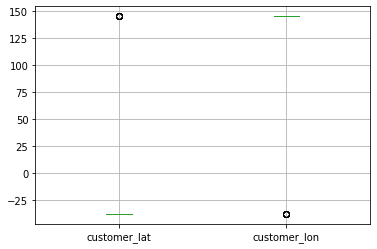

In [16]:
# Show boxplot of customer_lat and customer_lon
dirty_df[['customer_lat','customer_lon']].boxplot()

In [17]:
# Print data that looks suspicious for customer_lat (have extreme value)  
print(dirty_df.loc[dirty_df['customer_lat'] > 0,['order_id','customer_lat','customer_lon']])

# Print data that looks suspicious for customer_lon (have extreme value)
print(dirty_df.loc[dirty_df['customer_lon'] < 0,['order_id','customer_lat','customer_lon']])

      order_id  customer_lat  customer_lon
76   ORD296239    144.948589    -37.800020
141  ORD157228    144.956536    -37.811791
281  ORD049480    144.969411    -37.822472
385  ORD131469    144.957766    -37.800658
393  ORD068595    144.953359    -37.812306
460  ORD146532    144.956734    -37.822105
      order_id  customer_lat  customer_lon
76   ORD296239    144.948589    -37.800020
141  ORD157228    144.956536    -37.811791
281  ORD049480    144.969411    -37.822472
385  ORD131469    144.957766    -37.800658
393  ORD068595    144.953359    -37.812306
460  ORD146532    144.956734    -37.822105


**## Error 1 : Extreme values for customer_lat and customer_lon (suspicious to be swapped between lat and lon) ##**


**Fix 1 : Swapping values between customer_lat and customer_lon**

- Create conditions for the row that we want to swap lat and lon (customer latitude and longtitude to be greater than and less than 0.) 

- Swap the columns for the specified rows based on swap conditions

- Recheck customer latitude and longtitude again after swaping visually and numerically

In [18]:
# Create conditions for the row that we want to swap lat and lon 
swap_conditions = (dirty_df['customer_lat'] > 0) & (dirty_df['customer_lon'] < 0)

# Swap lat and lon for the specified rows 
dirty_df.loc[swap_conditions,['customer_lat','customer_lon']] = (dirty_df.loc[swap_conditions,['customer_lon','customer_lat']].values)

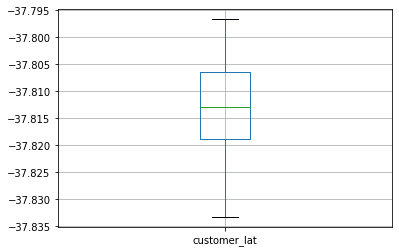

In [19]:
# Show boxplot of customer_lat and customer_lon
dirty_df[['customer_lat']].boxplot()

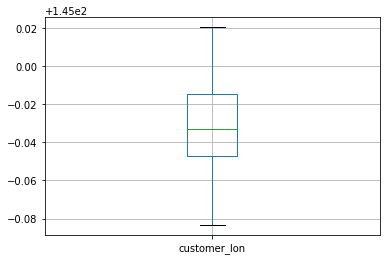

In [20]:
# Show boxplot of customer_lat and customer_lon
dirty_df[['customer_lon']].boxplot()

In [21]:
# Print data that looks suspicious for customer_lat (No more extreme value)  
print(dirty_df.loc[dirty_df['customer_lat'] > 0,['order_id','customer_lat','customer_lon']])

# Print data that looks suspicious for customer_lon (No more extreme value)
print(dirty_df.loc[dirty_df['customer_lon'] < 0,['order_id','customer_lat','customer_lon']])

Empty DataFrame
Columns: [order_id, customer_lat, customer_lon]
Index: []
Empty DataFrame
Columns: [order_id, customer_lat, customer_lon]
Index: []


###1.4 Checking Date and Time Columns

The date and time are supposed to follow the formats specified in the data dictionary. which are :

-  YYYY-MM-DD format for date column

- HH:MM:SS format for time column

Therefore, we initally perform date format checking 

**Date Format Checking**

In [22]:
# Check for date format errors

# Regex pattern that matches correct date format
correct_format_regex= r'\d{4}-(?:0\d|1[0-2])-(?:[0-3]\d)'

# Check whether each date rows follow the correct format or not
is_correct_format = dirty_df['date'].apply(lambda x : True if re.fullmatch(correct_format_regex,x) else False)

# Show the number of dates that follows correct(True) and incorrect format(False)
is_correct_format.value_counts()

True     490
False     10
Name: date, dtype: int64

In [23]:
# Show dates that do not follow correct format
incorrect_format_date = dirty_df.loc[-is_correct_format,'date']
print(incorrect_format_date)

10                   2020-25-05
28                   2020-19-07
30                  2020-Aug-07
97                   2020-14-01
182                  2020-15-02
189                  2020-24-02
299    Thu Dec 10 00:00:00 2020
382    Fri Dec 11 00:00:00 2020
424                 2020-Apr-07
495                  2020-24-07
Name: date, dtype: object


**## Error 2 : Inconsistent date format##**

**Fix 2 : Identifying all existing date formats and replacing with the correct one (YYYY-MM-DD )**

After we detect some format error, we have to identify all existing date format in the dataset, which does not match to the correct format. The incorrect formats are :

- YYYY-DD-MM (2020-25-05)

- YYYY-Mon-DD (2020-Aug-07)

- ddd Mon hh mm:ss.s YYYY (Thu Dec 10 00:00:00 2020)

To change the date format, we perform several steps :

 - Identify patterns and match incorrect format dates using regular expression
 - Fix the date formats utilising datetime datatype and replace with the correct format
 - Recheck the date format after fixing

In [24]:
# Identify patterns and match incorrect format dates 

# Write regular expression for each format specified above
YYYY_DD_MM_regex= r'\d{4}-(?:[0-3]\d)-(?:0\d|1[0-2])'
YYYY_Mon_DD_regex = r'\d{4}-(?:\w{3})-(?:[0-3]\d)'
withtime_regex = r'\w{3} \w{3} \d{2} \d{2}:\d{2}:\d{2} \d{4}'

# Match dates that have incorrect format and follow YYYY-DD-MM format 
YYYY_DD_MM_format = dirty_df['date'].apply(lambda x : True if re.fullmatch(YYYY_DD_MM_regex,x)  else False)
YYYY_DD_MM_format = ((YYYY_DD_MM_format) & (-is_correct_format))

# Match dates that have incorrect format and follow YYYY-Mon-DD format
YYYY_Mon_DD_format = dirty_df['date'].apply(lambda x : True if re.fullmatch(YYYY_Mon_DD_regex,x) else False)
YYYY_Mon_DD_format = ((YYYY_Mon_DD_format) & (-is_correct_format))

# Match dates that have incorrect format and ddd Mon hh mm:ss.s YYYY format 
# or Locale’s appropriate date and time representation (%c for Python)
withtime_format = dirty_df['date'].apply(lambda x : True if re.fullmatch(withtime_regex,x) else False)
withtime_format = ((withtime_format) & (-is_correct_format))




In [25]:
# Fix the date formats 

# Replace YYYY-DD-MM with YYYY-MM-DD format
dirty_df.loc[YYYY_DD_MM_format,'date'] =pd.to_datetime(dirty_df['date'][YYYY_DD_MM_format], 
                                                       format='%Y-%d-%m').dt.strftime("%Y-%m-%d")

# Replace YYYY-Mon-DD with YYYY-MM-DD format
dirty_df.loc[YYYY_Mon_DD_format,'date'] =pd.to_datetime(dirty_df['date'][YYYY_Mon_DD_format],
                                                        format='%Y-%b-%d').dt.strftime("%Y-%m-%d")
                                                        
# Replace Locale’s appropriate date and time representation with YYYY-MM-DD format
dirty_df.loc[withtime_format,'date'] =pd.to_datetime(dirty_df['date'][withtime_format],
                                                     format='%c').dt.strftime("%Y-%m-%d")

In [26]:
# Show the format of dates that we just fixed
print(dirty_df.loc[-is_correct_format,['date']])

           date
10   2020-05-25
28   2020-07-19
30   2020-08-07
97   2020-01-14
182  2020-02-15
189  2020-02-24
299  2020-12-10
382  2020-12-11
424  2020-04-07
495  2020-07-24


In [27]:
# Recheck that date format is already consistent

# Check again whether each date rows follow the correct format or not
dirty_df['date'].apply(lambda x : True if re.fullmatch(correct_format_regex,x) else False).value_counts()

True    500
Name: date, dtype: int64

**Time Format Checking**

In [28]:
# Check for time format errors

# Regex pattern that matches correct date format
correct_time_format_regex= r'[0-2]\d:[0-6]\d:[0-6]\d'

# Check whether each date rows follow the correct format or not
is_correct_time_format = dirty_df['time'].apply(lambda x : True if re.fullmatch(correct_time_format_regex,x) else False)

# Show the number of dates that follows correct(True) and incorrect format(False)
is_correct_time_format.value_counts()

True    500
Name: time, dtype: int64

There is no format inconsistency in time column

###1.5 Checking Boolean Columns Derived from Data and Time (is_peak_time, is_weekend)

As we know that these two columns are dependent to date and time columns, we want to check sematic anomaly in this part, which is contradiction. 

**Checking between is_weekend column from and is_weekend derived from date column**

- Convert date column to date format and store to new variable
- Create new df for is_weekend checking
- Add date columns from dirty_df
- Add day_of_week column extracted from date variable(datetime type)
- Flag is_weekend from the day of week column
- Add is_weekend column from the dirty_df
- Compare the results 

In [29]:
# Convert date column to date format and store to new variable
date = pd.to_datetime(dirty_df['date'],format='%Y-%m-%d')

# Create new df for is_weekend checking
is_weekend_check_df = pd.DataFrame()

# Add date columns from dirty_df
is_weekend_check_df['date'] = dirty_df['date']

# Add day_of_week column extracted from date variable(datetime type)
is_weekend_check_df['day_of_week'] = date.dt.dayofweek

# Flag is_weekend from the day of week column
is_weekend_check_df['is_weekend_from_day_of_week'] = np.where(is_weekend_check_df['day_of_week'].isin([5,6]),1,0)

# add is_weekend from the dirty_df
is_weekend_check_df['is_weekend_from_dirty_df'] = dirty_df['is_weekend']

# compare the results 
pd.crosstab(is_weekend_check_df['is_weekend_from_day_of_week'],dirty_df['is_weekend'])


is_weekend,0,1
is_weekend_from_day_of_week,,
0,353,2
1,3,142


In [30]:
# Create criteria if is_weekend_from_day_of_week is not equal to is_weekend from the dirty_df
wrong_is_weekend = is_weekend_check_df['is_weekend_from_day_of_week'] != is_weekend_check_df['is_weekend_from_dirty_df']

# Show the records that have different is_weekend 
is_weekend_check_df[wrong_is_weekend]

,date,day_of_week,is_weekend_from_day_of_week,is_weekend_from_dirty_df
74,2020-07-24,4,0,1
205,2020-08-22,5,1,0
266,2020-03-12,3,0,1
371,2020-05-16,5,1,0
455,2020-02-08,5,1,0


**## Error 3 : Contradiction between is_weekend and date##**

**Fix 3: Replace is_weekend that is extracted from the date to the wrong is_weekend**

- Replace is_weekend that is extracted from the date to the wrong is_weekend
- Recheck the results

In [31]:
# Replace the right is_weekend derived from day of week
dirty_df.loc[wrong_is_weekend,'is_weekend'] = is_weekend_check_df.loc[wrong_is_weekend,'is_weekend_from_day_of_week']

# Compare the results
pd.crosstab(is_weekend_check_df['is_weekend_from_day_of_week'],dirty_df['is_weekend'] )

is_weekend,0,1
is_weekend_from_day_of_week,,
0,355,0
1,0,145


In [32]:
# Check for the change
dirty_df.loc[wrong_is_weekend,['date','is_weekend']]

,date,is_weekend
74,2020-07-24,0
205,2020-08-22,1
266,2020-03-12,0
371,2020-05-16,1
455,2020-02-08,1


**Checking between is_peak_from_hour column from and is_peak_from_hour derived from time column with given criteria from specification**

- Convert time column to datetime format and store to new variable
- Create new df for is_peak_time checking
- Add time column from dirty_df
- Add hour column extracted from time variable(datetime type)
- Flag is_peak_time from hour column (condition is given in the specification)
- Add is_peak_time from the dirty_df
- Compare the results 

In [33]:
# Convert time column to datetime format and store to new variable
time = pd.to_datetime(dirty_df['time'],format='%X')

# Create new df for is_peak_from_hour checking
is_peak_check_df = pd.DataFrame()

# Add time column from dirty_df
is_peak_check_df['time'] = dirty_df['time']

# Add hour column extracted from time variable(datetime type)
is_peak_check_df['hour'] = time.dt.hour

# Flag is_peak_from_hour from hour column (condition is given in the specification)
is_peak_check_df['is_peak_from_hour'] = np.where(is_peak_check_df['hour'].isin([12,13,18,19]),1,0)

# Add is_peak_from_hour from the dirty_df
is_peak_check_df['is_peak_from_dirty_df'] = dirty_df['is_peak_time']

# compare the results 
pd.crosstab(is_peak_check_df['is_peak_from_hour'],dirty_df['is_peak_time'])


is_peak_time,0,1
is_peak_from_hour,,
0,400,6
1,0,94


In [34]:
# Create criteria if is_peak_from_hour is not equal to is_peak_from_dirty_df
wrong_is_peak = is_peak_check_df['is_peak_from_hour'] != is_peak_check_df['is_peak_from_dirty_df']

# Show the records that have different is_peak
is_peak_check_df[wrong_is_peak]

,time,hour,is_peak_from_hour,is_peak_from_dirty_df
26,17:44:10,17,0,1
83,01:27:01,1,0,1
137,09:49:27,9,0,1
176,15:09:53,15,0,1
186,04:32:58,4,0,1
380,00:51:25,0,0,1


**## Error 4 : Contradiction between is_peak_time and hour##**

**Fix 4: Replace is_peak_time that is extracted from the hour to the wrong is_peak_time**

- Replace is_peak_time that is extracted from the date to the wrong is_peak_time
- Recheck the results

In [35]:
# Replace the right is_peak_time derived from hours
dirty_df.loc[wrong_is_peak,'is_peak_time'] = is_peak_check_df.loc[wrong_is_peak,'is_peak_from_hour']

# compare the results 
pd.crosstab(is_peak_check_df['is_peak_from_hour'],dirty_df['is_peak_time'])

is_peak_time,0,1
is_peak_from_hour,,
0,406,0
1,0,94


###1.6 Checking Carrier Vehicle columns


Carrier Vehicle specified the data dictionary stated only 3 vehicle types (Bike, Motorbike, Car), but summary statistics show 6 unique types so we have to check further.

In [36]:
# Use value counts to show unique values with count
dirty_df['carrier_vehicle'].value_counts()

Bike         175
Car          161
Motorbike    157
bike           4
car            2
motorbike      1
Name: carrier_vehicle, dtype: int64

**## Error 5 : Cases Inconsistency in Carrier Vehicle##**

**Fix 5: Replace the Correct Cases to Carrier Vehicle**

- Replace the Correct Cases(specified in data dictionary) to Carrier Vehicle
- Check the result

In [37]:
# Replace the Correct Cases(specified in data dictionary) to Carrier Vehicle 
dirty_df.carrier_vehicle.replace({'bike' : 'Bike','car': 'Car','motorbike': 'Motorbike'},inplace=True)

In [38]:
# Check the result
dirty_df['carrier_vehicle'].value_counts()

Bike         179
Car          163
Motorbike    158
Name: carrier_vehicle, dtype: int64

###1.7 Checking Restaurant Rating

Restaurant rating is calculated based on given criteria in the requirement. Firstly, we check the restaurant rating in the dirty dataset

In [39]:
# Check the unique restaurant_id crossing with restaurant_rating
pd.crosstab(dirty_df['restaurant_id'],dirty_df['restaurant_rating'])

restaurant_rating,5.96,6.64,6.87,7.21,7.45,7.63,8.30,8.59,9.01,9.54
restaurant_id,,,,,,,,,,
REST0231,0,0,0,52,0,0,0,0,63,0
REST0423,0,0,0,0,0,48,0,0,0,40
REST0677,0,0,38,0,0,0,0,67,0,0
REST0761,42,0,0,0,51,0,0,0,0,0
REST0944,0,56,0,0,0,0,43,0,0,0


**## Error 6 : Restaurant Rating is not Matched with Calculattion criteria##**

- Each restaurant is supposed to have each restaurant rating based on sentimental analysis on reviews given in the specification

**Fix 6: Recalculating Restaurant Ratings and Replace them back**

- Find the unique restaurant id that exists in dirty_df
- Select only restaurant that exists in dirty_df from restaurant dataset
- Convert review_list column datatype from string to list
- Create function for calculating rating based on given criteria
- Apply calculate_rating function to generate restaurant_rating
- Drop old restaurant_rating column
- Join with select_rest_df to get new rating column
- Check the result

In [40]:
# Find the unique restaurant id that exists in dirty_df
rest_in_dirtydf = list(dirty_df['restaurant_id'].unique())

# Select only restaurant that exists in dirty_df from restaurant dataset
select_rest_df = restaurant_df.loc[restaurant_df['restaurant_id'].isin(rest_in_dirtydf),:]

# Convert review_list column datatype from string to list
select_rest_df.loc[:,'reviews_list'] = select_rest_df.loc[:,'reviews_list'].apply(lambda x:ast.literal_eval(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [41]:
# Create function for calculating rating
def calculate_rating(review_list) :
  
  # Create list of compound polarity score
  compound_score_list = []

  # Initialise SentimentIntensityAnalyzer
  analyser = SentimentIntensityAnalyzer()

  # For review in review list
  for review in review_list :

    # Calculate polarity score 
    score = analyser.polarity_scores(review)

    # Add to compound list
    compound_score_list.append(score['compound'])
  
  # Average compound list
  avg_polarity = sum(compound_score_list)/len(compound_score_list)
  
  # Calculate rating based on given formula
  rating = 10*(avg_polarity+0.9623)/(1.9533)

  # Return the rating
  return round(rating,2)
  

# Apply calculate_rating function to generate restaurant_rating
select_rest_df['restaurant_rating'] = select_rest_df['reviews_list'].apply(calculate_rating)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
# Drop old restaurant_rating column
dirty_df.drop('restaurant_rating', axis='columns', inplace=True)

# Join with select_rest_df to get new rating column
dirty_df =dirty_df.merge(select_rest_df[['restaurant_id','restaurant_rating']],how ='left',on ='restaurant_id')

In [43]:
# Check the result
pd.crosstab(dirty_df['restaurant_id'],dirty_df['restaurant_rating'])

restaurant_rating,7.45,8.30,8.59,9.01,9.54
restaurant_id,,,,,
REST0231,0,0,0,115,0
REST0423,0,0,0,0,88
REST0677,0,0,105,0,0
REST0761,93,0,0,0,0
REST0944,0,99,0,0,0


###1.8 Checking Shortest Distance to Customer Column



- Shortest Distance to Customer is derived from Dijkstra algorithm based on the nes and edges found in node.csv and edges so we can calculate these values and match those to the shortest distance to customer.

**## Error 7 : Shortest Distance to Customer is not Matched with Calculation Criteria##**

**Fix 7: Recalculating Shortest Distances to Customer and Replace them back**

- Create graph and add node,edge and weight(distance) to the graph
- Create dataframe that contains restaurant and customer latitude and longtitude
- Round latitude and longtitude of every columns to 7 decimal places in order to be consistent in every datasources
- Remove duplicates from node datset
- Join and manipulte data to get customer node and restaurant node
- Create shortest distance list and append the shortest path using dijkstra algorithm  for each route
- Replace old shortest_distance_to_customer to the new one derived by the given algorithm

In [44]:
### Create graph and add node,edge and weight(distance) to the graph ###
# Initialise graph object
G = nx.Graph()
for i in  range(0,len(edge_df.index)) :

  # Add graph, edge and weight 
  G.add_weighted_edges_from([(edge_df['u'][i], edge_df['v'][i], edge_df['distance(m)'][i])])

In [45]:
### Create dataframe that contains restaurant and customer latitude and longtitude ###

# Select restaurant_id customer_lat customer_lon from dirty dataset
distance_df = dirty_df[['restaurant_id','customer_lat','customer_lon']]

# Join to restaurant dataset to get restaurant_lat and restaurant_lon
distance_df = distance_df.merge(select_rest_df[['restaurant_id','lat','lon']],how ='left',on ='restaurant_id')

# Change the column names
distance_df.rename(columns = {'lat': 'restaurant_lat', 'lon': 'restaurant_lon'}, inplace = True)

In [46]:
### Round latitude and longtitude of every columns to 7 decimal places in order to be consistent in every datasources ###
distance_df['restaurant_lat'] = distance_df['restaurant_lat'].apply(lambda x: round(x,7))
distance_df['restaurant_lon'] = distance_df['restaurant_lon'].apply(lambda x: round(x,7))
distance_df['customer_lat'] = distance_df['customer_lat'].apply(lambda x: round(x,7))
distance_df['customer_lon'] = distance_df['customer_lon'].apply(lambda x: round(x,7))
node_df['lat'] = node_df['lat'].apply(lambda x: round(x,7))
node_df['lon'] = node_df['lon'].apply(lambda x: round(x,7))

In [47]:
### We found that there is node duplication in node dataset so we keep only one ###

# Print duplicate nodes with the same lat and lon in node_df
print(node_df[node_df.duplicated(['lat','lon'],keep =False)])

# Drop duplicate
node_df.drop_duplicates(['lat','lon'],inplace =True)

# Print duplicate nodes with the same lat and lon in node_df
print(node_df[node_df.duplicated(['lat','lon'],keep =False)])

             node        lat         lon
5320    243963290 -37.819726  144.969655
12603  6182893637 -37.819726  144.969655
12604  6182893638 -37.819726  144.969655
Empty DataFrame
Columns: [node, lat, lon]
Index: []


In [48]:
### Join and manipulte data to get customer node and restaurant node ###

# Join distance df with node_df to get node id for restaurant
distance_df = distance_df.merge(node_df,how ='left',left_on =['restaurant_lat','restaurant_lon'],right_on=['lat','lon'])

# rename node column name to restaurant_node
distance_df.rename(columns = {'node': 'restaurant_node'}, inplace = True)

# Drop lat lon columns
distance_df.drop(columns=['lat','lon'], inplace = True)

# Join distance df with node_df to get node id for customer
distance_df = distance_df.merge(node_df,how ='left',left_on =['customer_lat','customer_lon'],right_on=['lat','lon'])

# rename node column name to customer_node
distance_df.rename(columns = {'node': 'customer_node'}, inplace = True)

# Drop lat lon columns
distance_df.drop(columns=['lat','lon'], inplace = True)

In [49]:
### Create shortest distance list and append the shortest path using dijkstra algorithm  for each route ###
shortest_distance_list = []
for i in  range(0,len(distance_df.index)) :

  # Use dijkstra algorithm to find the shortest path given restaurant node and customer node
  shortest_distance = nx.single_source_dijkstra(G,source = distance_df['restaurant_node'][i], target = distance_df['customer_node'][i])
  
  # Append the shortest distance to  shortest distance list
  shortest_distance_list.append(shortest_distance[0])

In [50]:
# Show that statistics of differences between exiting dirty data 
# and shortest distance to customer
(dirty_df['shortest_distance_to_customer'] -shortest_distance_list).describe()

count     500.000000
mean      -27.496000
std       344.153869
min     -5004.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1874.000000
Name: shortest_distance_to_customer, dtype: float64

In [51]:
# Check number of mismatch between exiting dirty data and shortest distance to
# customer
((dirty_df['shortest_distance_to_customer'] -shortest_distance_list)!= 0).sum()

12

In [52]:
# Replace old shortest_distance_to_customer to the new one derived by the given algorithm
dirty_df['shortest_distance_to_customer'] = shortest_distance_list

###1.9 Checking Travel Time Minutes Column



Travel time minutes is derived from carrier vehicle type and distance from restaurant to customer

**## Error 8 : Travel time minutes is not Matched with Calculation Criteria##**

**Fix 8: Recalculating travel time minutes and replace them back**

- Initialise travel time list
- Assign avg speeds for different vehicles
- Calculate travel time(min) = [Distance(M)/1000] / avg_speed(km/hr)]*60 
- Append the result to the list
- Replace old travel_time_minutes to the new one derived by the given rule from specification

In [53]:
# Initialise travel time list
travel_time_list =[]

# for each record
for i in range(0,len(dirty_df.index)) :
  
  # If carrier_vehicle = Bike ,average speed = 12
  if dirty_df['carrier_vehicle'][i] == 'Bike' :
    average_speed = 12

  # If carrier_vehicle = Motobike ,average speed = 30
  elif dirty_df['carrier_vehicle'][i] == 'Motorbike' :
    average_speed = 30

  # If carrier_vehicle = Car ,average speed = 25 
  elif dirty_df['carrier_vehicle'][i] == 'Car' :
    average_speed = 25  
  
  # Calculate travel time(min) = [Distance(M)/1000] / avg_speed(km/hr)]*60  
  travel_time = round(((dirty_df['shortest_distance_to_customer'][i]/1000)/average_speed)*60)

  # Append the result to the list
  travel_time_list.append(travel_time)


In [54]:
# Show that statistics of differences between exiting dirty data 
# and shortest distance to customer
(dirty_df['travel_time_minutes'] -travel_time_list).describe()

count    500.000000
mean      -0.088000
std        1.080088
min      -13.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
Name: travel_time_minutes, dtype: float64

In [55]:
# Check number of mismatch between exiting dirty data and shortest distance to
# customer
((dirty_df['travel_time_minutes'] -travel_time_list)!= 0).sum()

18

In [56]:
# Replace old travel_time_minutes to the new one derived by the given rule from specification
dirty_df['travel_time_minutes'] = travel_time_list

###1.10 Checking Order Price

**## Error 9 : There is Inconsistent Order Price Given the Product Price##**

**Fix 9 : Create Product Master and Recalculate Order Price for Dirty Dataset**

####1.10.1 Creating Product Master

Before we can check the correctness of order price, which is  the
price of items in the shopping cart after applying coupon discount, price of each product is still missing. In practice, price of the products can be obtained from product master or product table that has detail about products. In this case, we will utilise data from missing dataset not the dirty dataset because we know that the missing dataset is assumed to be error-free except missing value. Our objective is to build product table that has product name and price inside. 

To do that we perform several step below :
- Check available products in the given restaurant (Product name is not unique or same product name can contain in multiple restaurants)
- Set the linear system equations that we want to solve. In this case, it is a multiplication of matrices

**All Product Units X  All Product Prices = Total Order Price** (We use full price before discount to calculate this equation),We know All Product Units and  Total Order Price, and want to solve for product prices
- Create order_product_df that each row represents product+restaurant level
- Pivot the order_product_df, which row represents order_id and column represents product + restaurant and value represent unit - **All Product Units**
- Create table that contains order price with order_id as an index and maintain the same order as order_product_pivot -  **Total Order Price**
- Convert two tables above to matrix (pivot order_product_df (**All Product Units**) and order_price (**Total Order Price**) ) to prepare for solving linear system equation
- Solve multiple linear equations toget **All Product Prices**
- Create **Product Master Table** that contains product name, restaurant ID and price used the results obtained from multiple linear equations
- Recheck with missing dataset

In [57]:
# Check available products in each restaurant 
rest_product_list = select_rest_df[['restaurant_id','menu_items']]
rest_product_list['menu_items'] = rest_product_list['menu_items'].apply(lambda x:ast.literal_eval(x))

rest_product_list =  rest_product_list.explode('menu_items').reset_index(drop = True)

# Explore available products in each restaurant 
pd.crosstab(rest_product_list['menu_items'],rest_product_list['restaurant_id'])

# Remark that pasta is available to multiple restaurant so product name is not unique across restuarant 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


restaurant_id,REST0231,REST0423,REST0677,REST0761,REST0944
menu_items,,,,,
bamboo chicken biryani,0,0,1,0,0
barbeque chicken,1,0,0,0,0
bbq chicken,1,0,0,0,0
brownie,0,1,0,0,0
burgers,0,0,0,1,0
buttermilk,0,1,0,0,0
cappuccino,0,0,0,0,1
cheese sticks,0,0,0,0,1
chicken biryani,1,0,0,0,0


In [58]:
### Create order_product_df that each row represent product+restaurant level ###

# Create order product df by obtaining order_id and shopping_cart from missing dataset
order_product_df = missing_df.loc[:,['order_id','shopping_cart','restaurant_id']]

# Change the shopping_cart type to list
order_product_df.loc[:,'shopping_cart'] = order_product_df.loc[:,'shopping_cart'].apply(lambda x:ast.literal_eval(x))

# Create new columns namely product and unit obtained from exploding shopping cart
order_product_df =  order_product_df.explode('shopping_cart').reset_index(drop = True)
order_product_df.loc[:,'product'] = order_product_df.loc[:,'shopping_cart'].apply(lambda x: x[0])
order_product_df.loc[:,'unit'] = order_product_df.loc[:,'shopping_cart'].apply(lambda x: x[1])

# Drop shopping cart column
order_product_df.drop(columns='shopping_cart', inplace = True)

# Create product_res that is a concatenation between product and restaurant ID
order_product_df['product_res'] = order_product_df['product'] +'_'+ order_product_df['restaurant_id']

In [59]:
# Create pivot table which row = order_id, columns = product+restaurant and value = unit
order_product_pivot = order_product_df.pivot_table(index='order_id', columns='product_res', values= 'unit').fillna(0)

# Create table that contains order price with order_id as an index and maintain the same order as order_product_pivot
order_price_pivot = pd.DataFrame(missing_df[['order_price','order_id','coupon_discount']]) 
order_price_pivot['full_order_price'] = order_price_pivot['order_price'] /(1-(order_price_pivot['coupon_discount']/100))
order_price_pivot.drop(columns= ['order_price','coupon_discount'] ,inplace= True)
order_price_pivot.set_index('order_id',inplace= True)
order_price_pivot= order_product_pivot.join(order_price_pivot)[['full_order_price']]

# Convert to matrices
order_product_matrix = order_product_pivot.to_numpy()
order_price_matrix = order_price_pivot.to_numpy()

In [60]:
#Solving multiple linear equations
product_price = np.linalg.lstsq(order_product_matrix,order_price_matrix)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [61]:
### Create Product Master Table that contains product name, restaurant ID and price 
# used the results obtained from multiple linear equations ###

# Initialise product master df
product_master = pd.DataFrame()

# Get the product+ restaurant column from order_product_pivot
product_master['product_res'] = order_product_pivot.columns

# Get the product price from Solving multiple linear equations
product_master['product_price']  = product_price

# Round the results to 2 decimal places
product_master['product_price']  = product_master['product_price'].round(2)

# Split product_res to product and restaurant_id columns
product_master['product_res'] = product_master['product_res'].str.split('_')
product_master['product'] = product_master['product_res'].apply(lambda x: x[0])
product_master['restaurant_id'] = product_master['product_res'].apply(lambda x: x[1])

# Drop the product_res
product_master.drop(columns='product_res',inplace= True)

In [62]:
 ### Recheck the correctness of price from product master in missing dataset ###

# Join order_product_df with product master to get price of each product
 join_product_master_df = order_product_df.merge(product_master,how ='left',on=['product','restaurant_id'])

 # Calculate total price of each order + product
 join_product_master_df['order_price_before_discount(master)'] =  join_product_master_df['unit']*join_product_master_df['product_price']

 # Group by order_id and get total order price using price from product master
 order_total_price_from_master_df= join_product_master_df[['order_id','order_price_before_discount(master)']].groupby(by='order_id').sum()

 # Left join to the missing datset with the order price derived using product master
check_order_price_df =missing_df[['order_id','order_price','coupon_discount']].merge(order_total_price_from_master_df
                                                                                     ,how ='left'
                                                                                    ,on='order_id')
# Apply coupon discount to order_price_before_discount(master)
check_order_price_df['order_price_after_discount(master)'] = check_order_price_df['order_price_before_discount(master)'] *(1-check_order_price_df['coupon_discount']/100)

# Round order price to get similar decimal to order_price
check_order_price_df['order_price_after_discount(master)'] = check_order_price_df['order_price_after_discount(master)'].round(3)

# Find the differences between order price from the dataset and from using price from product master
check_order_price_df['diff']= round(check_order_price_df['order_price'] - check_order_price_df['order_price_after_discount(master)'],3)

In [63]:
# Show  sample comparison between order price and order price derived from solved price
check_order_price_df.head(10)

,order_id,order_price,coupon_discount,order_price_before_discount(master),order_price_after_discount(master),diff
0,ORD255084,50.760,45,92.29,50.760,0.0
1,ORD321060,28.944,20,36.18,28.944,0.0
2,ORD133085,95.370,0,95.37,95.370,0.0
3,ORD026466,84.440,0,84.44,84.440,0.0
4,ORD190801,52.980,0,52.98,52.980,0.0
5,ORD287556,34.524,45,62.77,34.524,0.0
6,ORD082330,36.430,0,36.43,36.430,0.0
7,ORD082337,33.250,0,33.25,33.250,0.0
8,ORD126320,81.054,10,90.06,81.054,0.0
9,ORD009011,42.480,0,42.48,42.480,0.0


In [64]:
# Check the statistics
check_order_price_df.describe()

,order_price,coupon_discount,order_price_before_discount(master),order_price_after_discount(master),diff
count,500.000000,500.000000,500.000000,500.000000,500.0
mean,73.545930,14.900000,86.549480,73.545930,0.0
std,34.476343,17.894984,35.746871,34.476343,0.0
min,11.676000,0.000000,18.230000,11.676000,0.0
25%,48.363750,0.000000,57.500000,48.363750,0.0
50%,70.121000,10.000000,85.810000,70.121000,0.0
75%,94.685000,40.000000,110.795000,94.685000,0.0
max,197.480000,45.000000,197.480000,197.480000,0.0


As a result, we get the product master, which contains price information and is proven to give a correct order price in missing dataset. Therefore, price from the product master will be used to fix anomaly in dirty dataset

####1.10.2 Recalculate Order Price in Dirty Dataset

After the product master has been created, we can use price data along with product units in the shopping cart column with coupon discount to calculate total order price in each order. To do that we start from :

- Create order_product_dirty_df that each row represents product+restaurant level from dirty dataset
- Join order_product_dirty_df with product master to get price of each product and create join_dirty_product_master_df
- Calculate total price of each order + product in join_dirty_product_master_df
- Group by order_id and get total order price using price from product master and create dirty_order_total_price_from_master_df
- Left join to the dirty datset with the order price derived using product master to get order price and coupon discount and create check_dirty_order_price_df
- Apply coupon discount to order_price_before_discount(master)
- Round order price to get similar decimal to order_price
- Find the differences between order price from the dataset and from using price from product master
- Check records that contain mismatch (only 6 records)
- Replace order price in dirty dataset with order_price_after_discount(master) used price from product master


In [65]:
### Create order_product_dirty_df that each row represents product+restaurant level ###

# Create order product dirty df by obtaining order_id and shopping_cart from dirty dataset
order_product_dirty_df = dirty_df.loc[:,['order_id','shopping_cart','restaurant_id']]

# Change the shopping_cart type to list
order_product_dirty_df.loc[:,'shopping_cart'] = order_product_dirty_df.loc[:,'shopping_cart'].apply(lambda x:ast.literal_eval(x))

# Create new columns namely product and unit obtained from exploding shopping cart
order_product_dirty_df =  order_product_dirty_df.explode('shopping_cart').reset_index(drop = True)
order_product_dirty_df.loc[:,'product'] = order_product_dirty_df.loc[:,'shopping_cart'].apply(lambda x: x[0])
order_product_dirty_df.loc[:,'unit'] = order_product_dirty_df.loc[:,'shopping_cart'].apply(lambda x: x[1])

# Drop shopping cart column
order_product_dirty_df.drop(columns='shopping_cart', inplace = True)

In [66]:
# Join order_product_dirty_df with product master to get price of each product
join_dirty_product_master_df = order_product_dirty_df.merge(product_master,how ='left',on=['product','restaurant_id'])

 # Calculate total price of each order + product
join_dirty_product_master_df['order_price_before_discount(master)'] =  join_dirty_product_master_df['unit']\
                                                                        *join_dirty_product_master_df['product_price']

# Group by order_id and get total order price using price from product master
dirty_order_total_price_from_master_df= join_dirty_product_master_df[['order_id','order_price_before_discount(master)']]\
                                      .groupby(by='order_id').sum() 


# Left join to the dirty datset with the order price derived using product master to get order price and coupon discount
check_dirty_order_price_df =dirty_df[['order_id','order_price','coupon_discount']].merge(dirty_order_total_price_from_master_df
                                                                                     ,how ='left'
                                                                                    ,on='order_id')

# Apply coupon discount to order_price_before_discount(master)
check_dirty_order_price_df['order_price_after_discount(master)'] = check_dirty_order_price_df['order_price_before_discount(master)'] *(1-check_dirty_order_price_df['coupon_discount']/100)

# Round order price to get similar decimal to order_price
check_dirty_order_price_df['order_price_after_discount(master)'] = check_dirty_order_price_df['order_price_after_discount(master)'].round(3)

# Find the differences between order price from the dataset and from using price from product master
check_dirty_order_price_df['diff']= round(check_dirty_order_price_df['order_price'] - check_dirty_order_price_df['order_price_after_discount(master)'],3)

In [67]:
# Check records that contain mismatch (only 6 records)
check_dirty_order_price_df.sort_values(by = 'diff').head(10)

,order_id,order_price,coupon_discount,order_price_before_discount(master),order_price_after_discount(master),diff
15,ORD204890,31.740,0,104.18,104.180,-72.440
348,ORD060842,46.730,0,113.34,113.340,-66.610
5,ORD184022,91.056,0,151.76,151.760,-60.704
227,ORD170555,74.085,20,134.70,107.760,-33.675
384,ORD133203,96.201,0,117.86,117.860,-21.659
152,ORD319415,64.108,40,116.56,69.936,-5.828
0,ORD287671,50.670,0,50.67,50.670,0.000
331,ORD338002,72.290,0,72.29,72.290,0.000
332,ORD041637,28.989,10,32.21,28.989,0.000
333,ORD173200,116.790,0,116.79,116.790,0.000


In [68]:
# Replace order price with order_price_after_discount(master) used price from product master 
dirty_df['order_price'] = check_dirty_order_price_df['order_price_after_discount(master)'] 

###1.10 Writing CSV Output for Dirty Dataset Solution

In [69]:
# Writing CSV Output for Dirty Dataset Solution
dirty_df.to_csv('31258301_dirty_solution.csv', index = False)

###1.11 Summary for Task 1(Dirty Dataset)

In summary, we perform several checkings in the dirty dataset, which are:

- Overall Exploratory Data Analysis(EDA)
- Checking ID Columns (order_id, restaurant_id,customer_id,carrier_id, carrier_id)
- Checking Customer's Latitude and Longtitude Columns
- Checking Date and Time Columns
- Checking Boolean Columns Derived from Data and Time (is_peak_time, is_weekend)
- Checking Carrier Vehicle columns
- Checking Restaurant Rating
- Checking Shortest Distance to Customer Column
- Checking Travel Time Minutes Column
- Checking Order Price


We found 9 errors in dirty dataset consisting of :

- Error 1 : Extreme values for customer_lat and customer_lon (suspicious to be swapped between lat and lon)
- Error 2 : Inconsistent date format
- Error 3 : Contradiction between is_weekend and date
- Error 4 : Contradiction between is_peak_time and hour
- Error 5 : Cases Inconsistency in Carrier Vehicle
- Error 6 : Restaurant Rating is not Matched with Calculation criteria
- Error 7 : Shortest Distance to Customer is not Matched with Calculation Criteria
- Error 8 : Travel time minutes is not Matched with Calculation Criteria
- Error 9 : There is Inconsistent Order Price Given the Product Price

So we fix each error by :
- Fix 1 : Swapping values between customer_lat and customer_lon
- Fix 2 : Identifying all existing date formats and replacing with the correct one (YYYY-MM-DD )
- Fix 3: Replace is_weekend that is extracted from the date to the wrong is_weekend
- Fix 4: Replace is_peak_time that is extracted from the hour to the wrong is_peak_time
- Fix 5: Replace the Correct Cases to Carrier Vehicle
- Fix 6: Recalculating Restaurant Ratings and Replace them back
- Fix 7: Recalculating Shortest Distances to Customer and Replace them back
- Fix 8: Recalculating travel time minutes and replace them back
- Fix 9 : Create Product Master and Recalculate Order Price for Dirty Dataset

Finally, we write the output in CSV format of cleaned dirty dataset

## Task 2: Imputing the Missing Values in Missing Dataset

###2.1 Checking Columns that Contain Missing Values

In the part,we know that only error type that we have to fix is missing values so we focus on checking columns that contain missing values. 

In [70]:
# Check for missing columns
missing_df.isnull().sum()

order_id                           0
restaurant_id                      0
customer_id                        0
carrier_id                         0
customer_lat                       0
customer_lon                       0
date                               0
time                               0
is_peak_time                       0
is_weekend                         0
carrier_vehicle                    0
shopping_cart                      0
coupon_discount                    0
order_price                        0
shortest_distance_to_customer    150
travel_time_minutes                0
restaurant_rating                500
delivery_charges                 150
dtype: int64

In [71]:
# Show statistics for numerical values
missing_df.describe()

,customer_lat,customer_lon,is_peak_time,is_weekend,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,350.000000,500.000000,0.0,350.000000
mean,-37.812132,144.965504,0.138000,0.264000,14.900000,73.545930,2751.108571,8.660000,NaN,4.023825
std,0.007685,0.020730,0.345245,0.441241,17.894984,34.476343,1560.585013,6.427677,NaN,0.970639
min,-37.827489,144.910992,0.000000,0.000000,0.000000,11.676000,84.000000,0.000000,NaN,2.076000
25%,-37.819036,144.951554,0.000000,0.000000,0.000000,48.363750,1613.250000,4.000000,NaN,3.289250
50%,-37.812473,144.962698,0.000000,0.000000,10.000000,70.121000,2551.500000,7.000000,NaN,3.812900
75%,-37.805681,144.980390,0.000000,1.000000,40.000000,94.685000,3743.000000,11.000000,NaN,4.573800
max,-37.787433,145.016065,1.000000,1.000000,45.000000,197.480000,8654.000000,38.000000,NaN,7.782300


In [72]:
# Show statistics for categorical values
missing_df.describe(include= 'O')

,order_id,restaurant_id,customer_id,carrier_id,date,time,carrier_vehicle,shopping_cart
count,500,500,500,500,500,500,500,500
unique,500,5,490,478,269,258,3,490
top,ORD229840,REST0761,CUST01783,COUR3085,2020-07-29,12:43:30,Car,"[('pita bread', 2), ('peri peri chicken', 3)]"
freq,1,113,2,3,6,6,179,2


From the table above, the following columns have missing values, which are :

1.restaurant_rating

2.shortest_distance_to_customer

3.delivery_charges

In the following parts, we will impute each missing column with  appropriate approach

###2.2 Imputing Restaurant Rating Values

In restaurant rating column, it contains all null values, but fortunately, we know how to calculate the rating. The process is similar to section 1.7 Checking Restaurant Rating above when dealing with rating with dirty data. In this part, we will calculate rating from restaurant dataset and join back to missing dataset.

In [73]:
# Find the unique restaurant id that exists in missing_df
rest_in_missingdf = list(missing_df['restaurant_id'].unique())

# select only data that exists in missing_df
select_rest_missdf = restaurant_df.loc[restaurant_df['restaurant_id'].isin(rest_in_missingdf),:]

# Convert review_list column to list
select_rest_missdf.loc[:,'reviews_list'] = select_rest_missdf.loc[:,'reviews_list'].apply(lambda x:ast.literal_eval(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [74]:
# Apply calculate_rating function to generate restaurant_rating 
# (Function is generated in 1.7 Checking Restaurant Rating ) when dealing with dirty data
select_rest_missdf['restaurant_rating'] = select_rest_missdf['reviews_list'].apply(calculate_rating)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
# Drop old restaurant_rating column
missing_df.drop('restaurant_rating', axis='columns', inplace=True)

# Join with select_rest_missdf to get new rating column
missing_df =missing_df.merge(select_rest_missdf[['restaurant_id','restaurant_rating']],how ='left',on ='restaurant_id')

###2.3 Imputing Shortest Distance to Customer

For this part, we want to impute shortest distance to customer.This field can be derived from the algorithm specified in specification that is similar to section 1.8 Checking Shortest Distance to Customer Column To tackle this problem, we use the same approaches as section 1.8

In [76]:
### Create dataframe that contains restaurant and customer latitude and longtitude ###

# Select restaurant_id customer_lat customer_lon from dirty dataset
distance_df_missing = missing_df[['restaurant_id','customer_lat','customer_lon']]

# Join to restaurant dataset to get restaurant_lat and restaurant_lon
distance_df_missing = distance_df_missing.merge(select_rest_df[['restaurant_id','lat','lon']],how ='left',on ='restaurant_id')

# Change the column names
distance_df_missing.rename(columns = {'lat': 'restaurant_lat', 'lon': 'restaurant_lon'}, inplace = True)

In [77]:
### Round latitude and longtitude of every columns to 7 decimal places in order to be consistent in every datasources ###
distance_df_missing['restaurant_lat'] = distance_df_missing['restaurant_lat'].apply(lambda x: round(x,7))
distance_df_missing['restaurant_lon'] = distance_df_missing['restaurant_lon'].apply(lambda x: round(x,7))
distance_df_missing['customer_lat'] = distance_df_missing['customer_lat'].apply(lambda x: round(x,7))
distance_df_missing['customer_lon'] = distance_df_missing['customer_lon'].apply(lambda x: round(x,7))


In [78]:
### Join and manipulte data to get customer node and restaurant node ###

# Join distance df with node_df to get node id for restaurant
distance_df_missing = distance_df_missing.merge(node_df,how ='left',left_on =['restaurant_lat','restaurant_lon'],right_on=['lat','lon'])

# rename node column name to restaurant_node
distance_df_missing.rename(columns = {'node': 'restaurant_node'}, inplace = True)

# Drop lat lon columns
distance_df_missing.drop(columns=['lat','lon'], inplace = True)

# Join distance df with node_df to get node id for customer
distance_df_missing = distance_df_missing.merge(node_df,how ='left',left_on =['customer_lat','customer_lon'],right_on=['lat','lon'])

# rename node column name to customer_node
distance_df_missing.rename(columns = {'node': 'customer_node'}, inplace = True)

# # Drop lat lon columns
distance_df_missing.drop(columns=['lat','lon'], inplace = True)


In [79]:
### Create shortest distance list and append the shortest path using dijkstra algorithm  for each route ###
# Remark G is a graph instance that's already created in sectio 1.8 Checking shortest distan to customer
shortest_distance_missing_list = []

for i in  range(0,len(distance_df_missing.index)) :

  # Use dijkstra algorithm to find the shortest path given restaurant node and customer node
  shortest_distance_missing = nx.single_source_dijkstra(G,source = distance_df_missing['restaurant_node'][i], target = distance_df_missing['customer_node'][i])
  # Append the shortest distance to  shortest distance list
  shortest_distance_missing_list.append(shortest_distance_missing[0])

In [80]:
# Impute shortest_distance_to_customer by using the given algorithm
missing_df['shortest_distance_to_customer'][missing_df['shortest_distance_to_customer'].isnull()] = shortest_distance_missing_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


###2.4 Imputing Delivery Charges

Delivery chareges can be calculated by linear regression with 'travel_time_minutes','is_peak_time','is_weekend' and 'restaurant_rating' as features (given in the requirement). Therefore, we train model on the rows that have complete data on these features and target variable (delivery charges) to get linear model. After that, we use that model to predict delivery charges and use these values for imputation

In [81]:
# Create new dataframe that we will drop all row that contain null value in missing_impute_df['delivery_charges']
missing_dropna_df =missing_df.copy()
missing_dropna_df.dropna(subset=['delivery_charges'],axis = 0, inplace=True)

# Subset for feature X and output Y that use for the model
lm_fitting_df_X = missing_dropna_df[['travel_time_minutes','is_peak_time','is_weekend','restaurant_rating']]
lm_fitting_df_Y = missing_dropna_df['delivery_charges']


In [82]:
# Initialise linear regression
lm_for_impute = LinearRegression()

# Fit the model on the missing_dropna_df
lm_for_impute.fit(lm_fitting_df_X,lm_fitting_df_Y)

# Use the model to predict delivery charges
pred = lm_for_impute.predict(missing_df[['travel_time_minutes','is_peak_time','is_weekend','restaurant_rating']])

In [83]:
# Show delivery_charges before imputation
missing_df['delivery_charges']

0         NaN
1      4.2142
2      2.7626
3      4.9467
4         NaN
        ...  
495       NaN
496    5.8584
497    3.9738
498    4.5963
499       NaN
Name: delivery_charges, Length: 500, dtype: float64

In [84]:
# show first 5 prediction results
print(pred[:10])

[4.63940251 4.40105522 2.96987465 4.85013308 4.89026367 3.80218263
 3.44511474 5.46297403 3.8921427  5.65804404]


In [85]:
# Impute the columns that contain missing values
missing_df['delivery_charges'][missing_df['delivery_charges'].isnull()] =pred

# Show delivery_charges after imputation
missing_df['delivery_charges']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0      4.639403
1      4.214200
2      2.762600
3      4.946700
4      4.890264
         ...   
495    3.065133
496    5.858400
497    3.973800
498    4.596300
499    4.101619
Name: delivery_charges, Length: 500, dtype: float64

###2.5 Writing CSV Output for Missing Dataset Solution

In [86]:
# Writing CSV Output for Missing Dataset Solution
missing_df.to_csv('31258301_missing_solution.csv', index = False)

###2.6 Summary for Task 2 (Missing Dataset)

In [87]:
# Check for missing columns
missing_df.isnull().sum()

order_id                         0
restaurant_id                    0
customer_id                      0
carrier_id                       0
customer_lat                     0
customer_lon                     0
date                             0
time                             0
is_peak_time                     0
is_weekend                       0
carrier_vehicle                  0
shopping_cart                    0
coupon_discount                  0
order_price                      0
shortest_distance_to_customer    0
travel_time_minutes              0
delivery_charges                 0
restaurant_rating                0
dtype: int64

In summary, we explore the missing dataset and investigate attributes that contain null values. We impute 3 columns, which are :

- Imputing Restaurant Rating Values -  use similar approach as section 1.7 Checking Restaurant Rating
- Imputing Shortest Distance to Customer - use similar approach assection 1.8 Checking Shortest Distance to Customer Column
- Imputing Delivery Charges - train model on the rows that have complete data on these features and target variable (delivery charges) to get linear model. After that, we use that model to predict delivery charges and use these values for imputation

As a result, final output contains no null columns shown in table above and we export cleaned output to csv file

## Task 3: Detecting and Removing Outlier Rows in Outlier Dataset

In this task, we are asked to remove outliers with respect to delivery charges attribute in outlier dataset

####3.1 EDA for Outliers

Firstly, we start from exploring outlier dataset. Fortunately, we have information that delivery charge is calculated using linear model, which depends on travel_time_minutes, is_peak_time, is_weekend and restaurant rating. In other words, delivery charge is dependent on other factors. In this part, we use boxplot and scatterplot to give an overview of delivery charge distribution and delivery charge VS other factors 

In [88]:
# Briefly look at information about this dataset (No restaurant rating) 
outlier_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   restaurant_id                  500 non-null    object 
 2   customer_id                    500 non-null    object 
 3   carrier_id                     500 non-null    object 
 4   customer_lat                   500 non-null    float64
 5   customer_lon                   500 non-null    float64
 6   date                           500 non-null    object 
 7   time                           500 non-null    object 
 8   is_peak_time                   500 non-null    int64  
 9   is_weekend                     500 non-null    int64  
 10  carrier_vehicle                500 non-null    object 
 11  shopping_cart                  500 non-null    object 
 12  coupon_discount                500 non-null    int

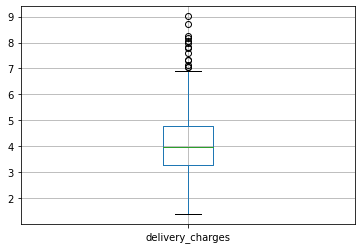

In [89]:
# Using boxplot to look at delivery charges distribution and potential outliers
outlier_df.boxplot(column= 'delivery_charges')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


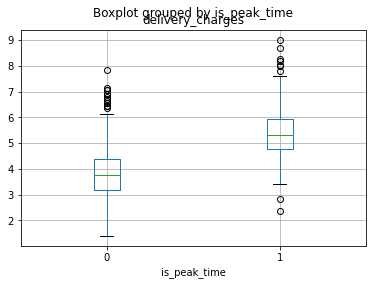

In [90]:
# Using boxplot to look at delivery charges by is_peak_time
outlier_df.boxplot(column= 'delivery_charges', by = 'is_peak_time')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


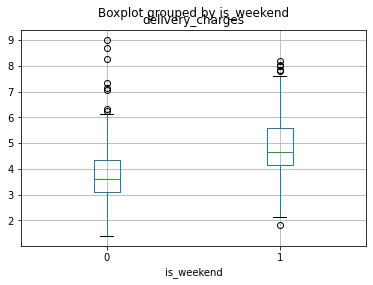

In [91]:
 # Using boxplot to look at delivery charges by is_weekend
 outlier_df.boxplot(column= 'delivery_charges', by = 'is_weekend')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


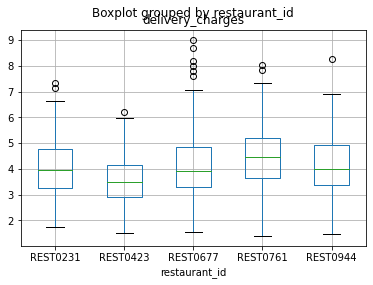

In [92]:
# Using boxplot to look at delivery charges by restaurant_id
outlier_df.boxplot(column= 'delivery_charges', by = 'restaurant_id') 

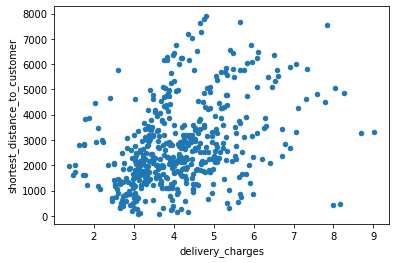

In [93]:
# Using boxplot to look at delivery charges by restaurant_id
outlier_df.plot.scatter(x= 'delivery_charges', y = 'shortest_distance_to_customer')

From the figures above,they illustrate only one or two dimensional data, which gives an overview of delivery charge and how the varible relates to other factors with potetial outliers. However, outliers in higher dimension cannot be easily detected from the previous graphs, so we will utilise linear regression, which we know that delivery charge is derived from this model, and look at distribution of residuals.

####3.2 Detecting Outlier from Linear Model

As we mention in the previous section, we will train linear model and look at residual distribution from the model to identify potential outliers. The following steps are performed

- Prepare features for linear model
- Fit the model 
- Use the model to predict delivery charges
- Create residual df to compare predicted and actual results with residual
- Visualise residual using boxplot
- Visualise residual VS predicted delivery charge using scatterplot
- Visualise actual VS predicted delivery charge using scatterplot


In [94]:
# Prepare features for linear model
outlier_features = outlier_df[['travel_time_minutes','is_peak_time','is_weekend','restaurant_id']]
outlier_features = outlier_features.merge(select_rest_df[['restaurant_id','restaurant_rating']],how ='left',on ='restaurant_id')
outlier_features.drop(columns= 'restaurant_id',inplace=True)

# Prepare labels for linear model
outlier_label = outlier_df['delivery_charges']

In [95]:
# Initialise linear regression
lm_for_outlier = LinearRegression()

# Fit the model 
lm_for_outlier.fit(outlier_features,outlier_label)

# Use the model to predict delivery charges
pred_outlier = lm_for_outlier.predict(outlier_features[['travel_time_minutes','is_peak_time','is_weekend','restaurant_rating']])


In [96]:
# Create residual df to compare predicted and actual results with residual
residual_df = pd.DataFrame()
residual_df['actual_delivery_charges'] = outlier_label
residual_df['predicted_delivery_charges'] = pred_outlier
residual_df['residual'] = outlier_label-pred_outlier

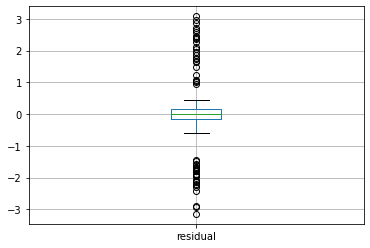

In [97]:
# Visualise residual using boxplot
residual_df[['residual']].boxplot()

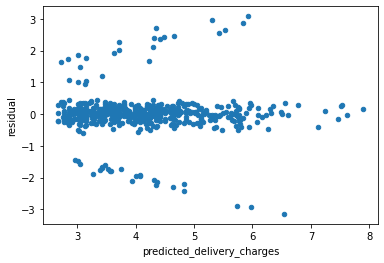

In [98]:
# Visualise residual VS predicted delivery charge using scatterplot
residual_df.plot.scatter(x= 'predicted_delivery_charges', y = 'residual')

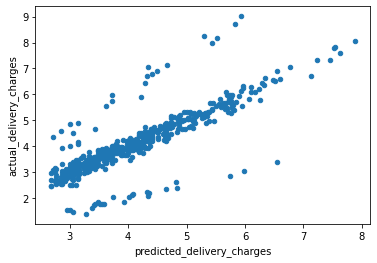

In [99]:
# Visualise actual VS predicted delivery charge using scatterplot
residual_df.plot.scatter(x= 'predicted_delivery_charges', y = 'actual_delivery_charges')

####3.3 Removing Outlier 

After the linear model is trained, we can use residual from the predicted vs actual results as a measurement to identify outliers. Detecting outliers can be done several ways, in this case, we will use :

- Quartile-based Detection and Boxplot
- The 3 std edit rule
- The Hampel Identifier

on the residual from the linear model. After that we will try to remove outliers for each criteria and use graphic visualisation to look at residual distribution, residual VS predicted delivery charge and actual VS predicted delivery charge.

Quartile-based Detection and Boxplot

In [100]:
  # Find q1 and q3
  quantile1 = residual_df['residual'].quantile(0.25)
  quantile3 = residual_df['residual'].quantile(0.75)

  # Calculate Interquatile range
  IQR = quantile3 - quantile1

  # Find lower and upper whisker
  lower_whisker = quantile1 - (1.5*IQR)
  upper_whisker = (quantile3 + (1.5 * IQR))

# Identify outliers
  outlier_boxplot_check = (residual_df['residual'] > upper_whisker) | (residual_df['residual'] < lower_whisker)
 
 # Remove outlier using quartile based detection
  without_boxplot_outlier_df = residual_df[~outlier_boxplot_check]

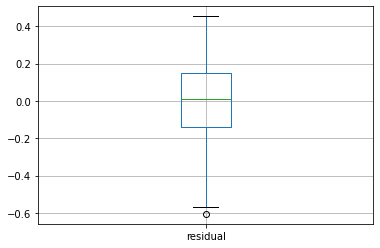

In [101]:
# Visualise residual using boxplot
without_boxplot_outlier_df[['residual']].boxplot()

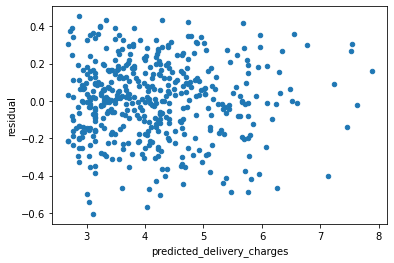

In [102]:
# Visualise residual VS predicted delivery charge using scatterplot
without_boxplot_outlier_df.plot.scatter(x= 'predicted_delivery_charges', y = 'residual')

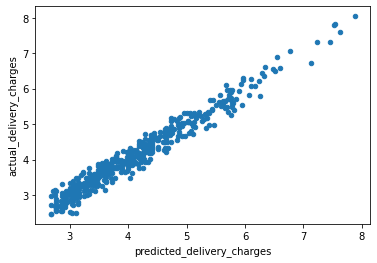

In [103]:
# Visualise actual VS predicted delivery charge using scatterplot
without_boxplot_outlier_df.plot.scatter(x= 'predicted_delivery_charges', y = 'actual_delivery_charges')

In [104]:
# Show the shape of data after removing outlier
without_boxplot_outlier_df.shape

(450, 3)

The 3 std edit rule

In [105]:
# Calculate mean
rs_mean = np.mean(residual_df['residual'])

# Calculate standard deviation
rs_std = np.std(residual_df['residual'])

# Find lower and upper bound (mu+3std)
upper_bound_3std = rs_mean + 3*rs_std
lower_bound_3std = rs_mean - 3*rs_std

# Remove outlier using 3std rule
outlier_check_std = (residual_df['residual'] > upper_bound_3std) | (residual_df['residual'] < lower_bound_3std)

# Remove outlier using quartile based detection
without_std_outlier_df = residual_df[~outlier_check_std]


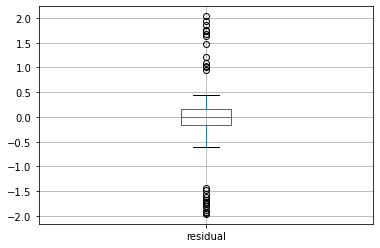

In [106]:
# Visualise residual using boxplot
without_std_outlier_df[['residual']].boxplot()

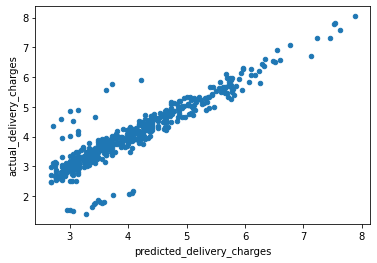

In [107]:
#  Visualise residual VS predicted delivery charge using scatterplot
without_std_outlier_df.plot.scatter(x= 'predicted_delivery_charges', y = 'actual_delivery_charges')

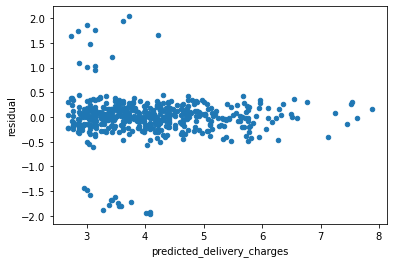

In [108]:
# Visualise actual VS predicted delivery charge using scatterplot
without_std_outlier_df.plot.scatter(x= 'predicted_delivery_charges', y = 'residual')

In [109]:
without_std_outlier_df.shape

(478, 3)

The Hampel Identifier

In [110]:
# Caculating Zeta
s = 1.4826 * np.median(np.absolute(residual_df['residual']- np.median(residual_df['residual'])))

# Check the outliers
outlier_check_hampel = (np.absolute(residual_df['residual'] - np.median(residual_df['residual'])) > 3*s)

# Remove the outliers
without_hampel_outlier_df = residual_df[~outlier_check_hampel]

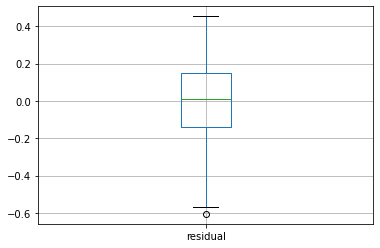

In [111]:
# Visualise residual using boxplot
without_hampel_outlier_df[['residual']].boxplot()

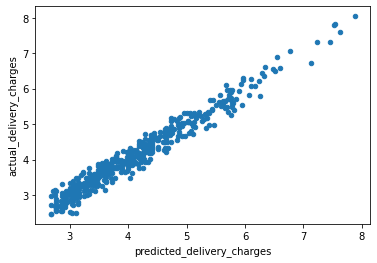

In [112]:
# Visualise actual VS predicted delivery charge using scatterplot
without_hampel_outlier_df.plot.scatter(x= 'predicted_delivery_charges', y = 'actual_delivery_charges')

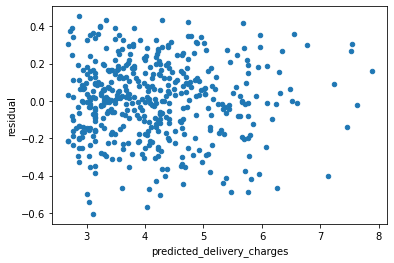

In [113]:

#  Visualise residual VS predicted delivery charge using scatterplot
without_hampel_outlier_df.plot.scatter(x= 'predicted_delivery_charges', y = 'residual')

In [114]:
without_hampel_outlier_df.shape

(450, 3)

As a result, we design to remove outliers from outlier dataset using Quartile-based Detection and Boxplot since it gives satisfied results from the plots, which are :

-Residual using boxplot - Most data is distributed between upper and lower whisker

-Actual VS Predicted delivery charge scatterplot - these two values seem to have nice linear relationship

-Residual VS Predicted delivery - The residual seems to be random as predicted value increases satisfying homoscedasticity assumption for linear regression

In [115]:
# Remove outlier
outlier_df = outlier_df[~outlier_boxplot_check]

In [116]:
outlier_df.shape

(450, 17)

###3.3 Writing CSV Output for Outlier Dataset Solution

In [117]:
# Writing CSV Output for outlier Dataset Solution
outlier_df.to_csv('31258301_outlier_solution.csv', index = False)

###3.4 Summary for Task 3 (Outlier data)

First, we start from EDA for outliers in delivery charge column, then we develop linear model and obtain residual of each data point. After that, we use boxplot and scatterplot to visualise and detect potential outliers. Finally, we use quantile-based and boxplot method to remove those outliers and visualise the graph to make sure that removing outliers is a appropriate method for this column